In [1]:
# Run this for Google CoLab
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
pip install fuzzywuzzy

In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
import numpy as np
import pandas as pd
import gensim
import scipy
import spacy
from fuzzywuzzy import fuzz
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from scipy.stats import skew, kurtosis
from scipy.spatial.distance import cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis
from scipy.stats import skew, kurtosis
import gensim
from gensim.models import Word2Vec
from nltk import word_tokenize
from nltk.corpus import stopwords
from spacy.lang.en.stop_words import STOP_WORDS

from tqdm import tqdm_notebook
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [0]:
input_folder = '/content/drive/My Drive/projects/kaggle/'

In [0]:
df = pd.read_csv(input_folder + 'train.csv')
df_test = pd.read_csv(input_folder + 'test.csv')

In [7]:
df.head()

,id,sent1,sent2,same_source
0,1,"June – Moctezuma II, Aztec ruler of Tenochtitl...",The Swedish regent Sten Sture the Younger is m...,1
1,2,"The population was 1,097 at the 2010 census.",Like other Latino neighborhoods in New York Ci...,0
2,3,Europe and the Islamic World: A History.,There are no plans to resurrect it.,0
3,4,"Even where only a small charge is produced, it...",The Clarion-Limestone Area School District pro...,0
4,5,The highlight of Croatias recent infrastructur...,The closest analogy with the modern Web browse...,0


In [0]:
df = df.dropna(how="any").reset_index(drop=True)

same_source
0    64515
1    64641
Name: id, dtype: int64


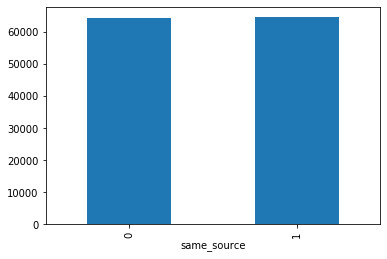

In [9]:
# check whether the data is balanced or not
print(df.groupby("same_source")['id'].count())
df.groupby("same_source")['id'].count().plot.bar()

In [10]:
train_size=df.shape[0]
test_size=df_test.shape[0]
df.drop(['id'], axis=1, inplace=True)
id_test=df_test['id']
df_test.drop(['id'], axis=1, inplace=True)
df.head()

,sent1,sent2,same_source
0,"June – Moctezuma II, Aztec ruler of Tenochtitl...",The Swedish regent Sten Sture the Younger is m...,1
1,"The population was 1,097 at the 2010 census.",Like other Latino neighborhoods in New York Ci...,0
2,Europe and the Islamic World: A History.,There are no plans to resurrect it.,0
3,"Even where only a small charge is produced, it...",The Clarion-Limestone Area School District pro...,0
4,The highlight of Croatias recent infrastructur...,The closest analogy with the modern Web browse...,0


In [0]:
df_all=pd.concat([df[['sent1','sent2']],df_test],axis=0)

tf-idf based on words

In [0]:
tfidf_vect = TfidfVectorizer(analyzer='word',min_df=3,token_pattern=r'\w{1,}',ngram_range=(1,2),max_features=5000)
tfidf_vect.fit(pd.concat((df_all['sent1'],df_all['sent2'])).unique())
trainq1_trans = tfidf_vect.transform(df_all['sent1'].values)
trainq2_trans = tfidf_vect.transform(df_all['sent2'].values)
fs_tfidf_word_all = scipy.sparse.hstack((trainq1_trans,trainq2_trans))

In [13]:
fs_tfidf_word_all.shape

(143506, 10000)

tf-idf based on characters

In [0]:
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char',min_df=3, token_pattern=r'\w{1,}',ngram_range=(1,2), max_features=5000)
tfidf_vect_ngram_chars.fit(pd.concat((df_all['sent1'],df_all['sent2'])).unique())
trainq1_trans = tfidf_vect_ngram_chars.transform(df_all['sent1'].values)
trainq2_trans = tfidf_vect_ngram_chars.transform(df_all['sent2'].values)
fs_tfidf_char_all = scipy.sparse.hstack((trainq1_trans,trainq2_trans))

Use xgboost to train

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score
import xgboost as xgb

In [16]:
X = scipy.sparse.hstack((fs_tfidf_char_all,fs_tfidf_word_all))
print(X.shape)

(143506, 18770)


In [0]:
y = df.loc[:, df.columns == 'same_source']
df_train, Test = train_test_split(X,train_size=train_size, random_state=42,shuffle=False)

In [0]:
model = xgb.XGBClassifier(max_depth=80, n_estimators=480, learning_rate=0.06, 
                          colsample_bytree=.7, gamma=0, reg_alpha=3.8, objective='binary:logistic', 
                          silent=0, subsample=0.85).fit(df_train, y.values.ravel())

In [0]:
pred=model.predict_proba(Test)[:,1]
submission = pd.DataFrame()
submission['Id'] = id_test
submission['same_source'] = pred
submission.to_csv('xgboost.csv', index = False)